In [1]:
#importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer,OneHotEncoder, StandardScaler, normalize
from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from scipy import stats

# Uploading the Data

Data Information
1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

In [2]:
#uploading the document
df=pd.read_csv('../../heart.csv')

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Cleaning and Understanding Data

In [4]:
#shows all the columns that we have
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [5]:
#gives the types of the columns that we have
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [6]:
# we have a total of 918 rows and 12 columns
df.shape

(918, 12)

In [7]:
#We have a balanced data set
df.HeartDisease.value_counts(normalize=True)

HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64

In [8]:
#checking if we have duplicated data
#we dont have duplicated data
duplicates= df[df.duplicated()]
print(len(duplicates))

0


In [9]:
#checking if we have NaN Values
#we dont have null values
null_values=df.isna().sum()
null_values

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Now, we will be analyzing each individual column to find the patterns and understand the distribution of the dataset.

1. What is the distribution of Age in the dataset?
    * This visualization will help us understand the age distribution of patients with heart disease. It will help us identify if there is a specific age group that is more prone to heart disease.
    * We are able to see that in general, people between ages from 50-65 tend to have a heart disease

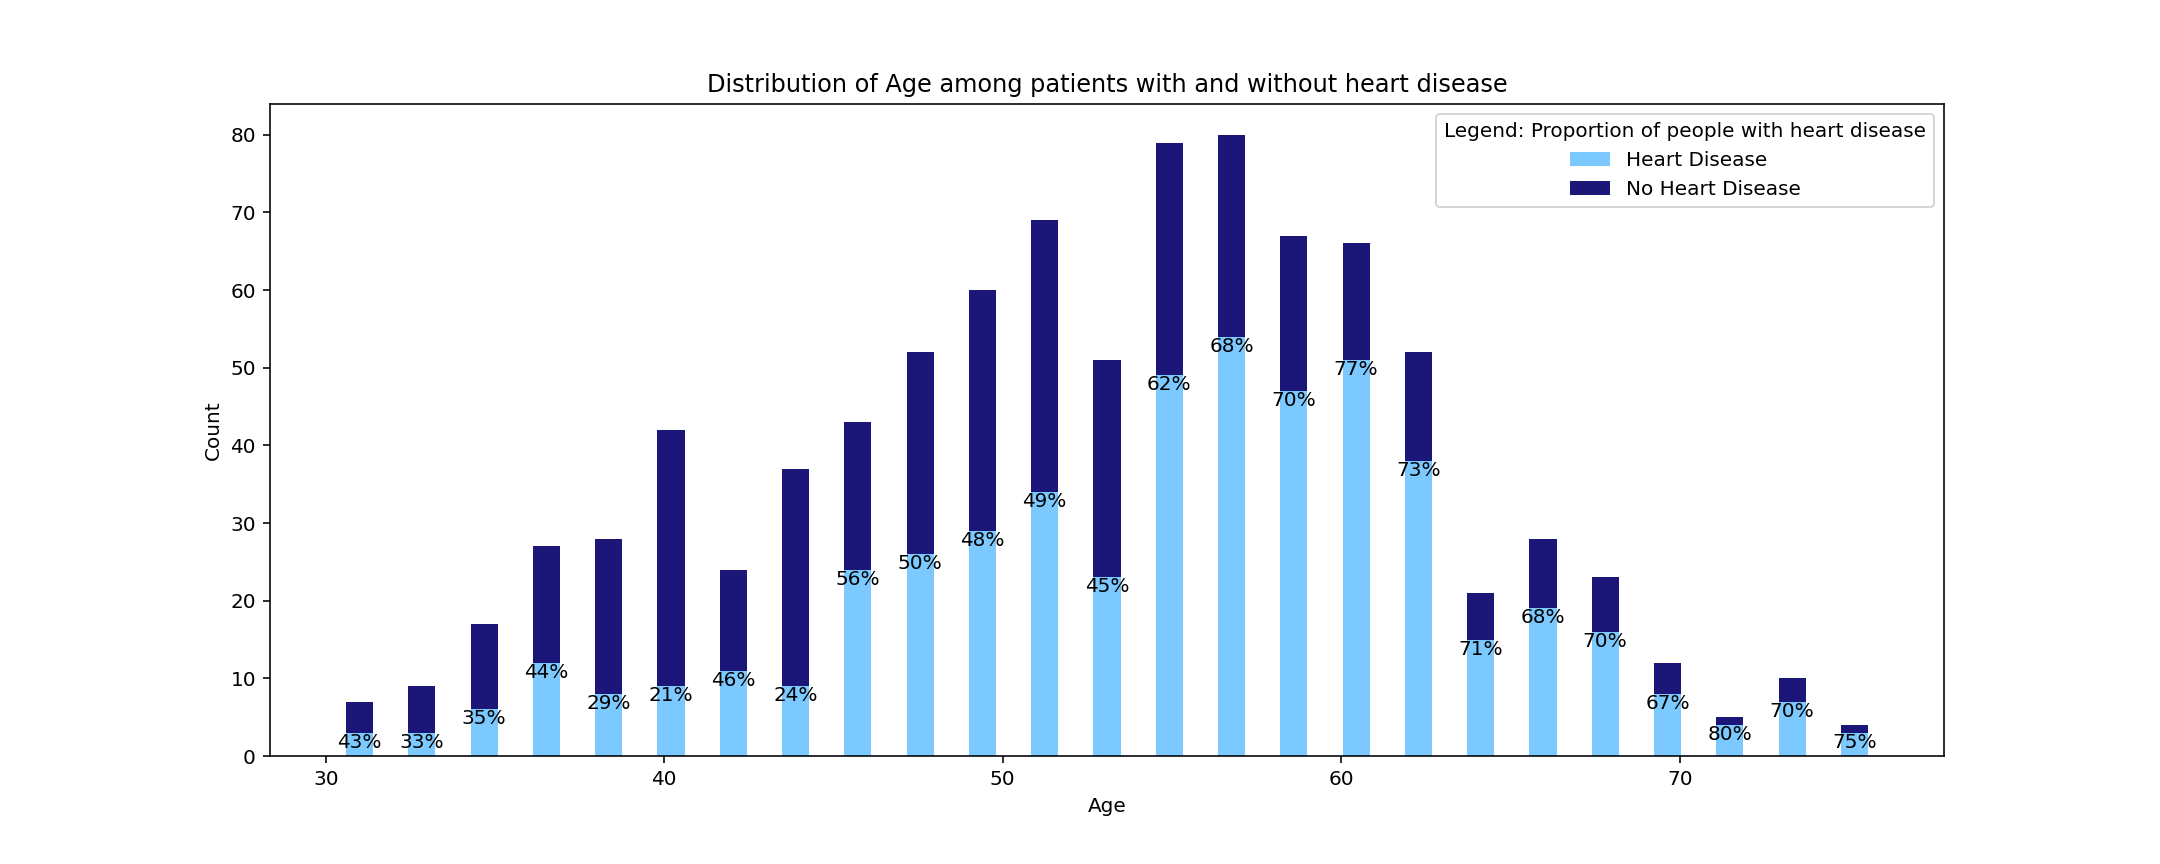

In [33]:
# Data filtered by HeartDisease status
hd_data = df[df['HeartDisease'] == 1]
no_hd_data = df[df['HeartDisease'] == 0]

# Calculate histogram for both groups
hd_hist, hd_bins = np.histogram(hd_data['Age'], bins=25)
no_hd_hist, _ = np.histogram(no_hd_data['Age'], bins=hd_bins)

# Calculating total counts per bin (sum of hd_hist and no_hd_hist)
total_hist = hd_hist + no_hd_hist

# Calculating the percentage of patients with heart disease in each bin
percentage_hd = (hd_hist / total_hist) * 100

# Plotting stacked histograms
plt.figure(figsize=(15, 6))
bars_hd = plt.bar(hd_bins[:-1], hd_hist, color='#7BC9FF', label='Heart Disease')
bars_no_hd = plt.bar(hd_bins[:-1], no_hd_hist, bottom=hd_hist, color='#1C1678', label='No Heart Disease')

# Adding axis labels and title
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age among patients with and without heart disease', wrap=True)
plt.legend(title='Legend: Proportion of people with heart disease')

# Adding percentage labels
for bar, percentage in zip(bars_hd, percentage_hd):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.0f}%', ha='center', va='top', color='black')

plt.show()

2. What is the gender distribution of the patients in the dataset?
    * This visualization will help us understand the gender distribution of the patients in the dataset and identify any potential gender-based patterns or trends.
    * we can see that our data tends to be skewed toward males
    * In addition male are more propense to have a heart disease

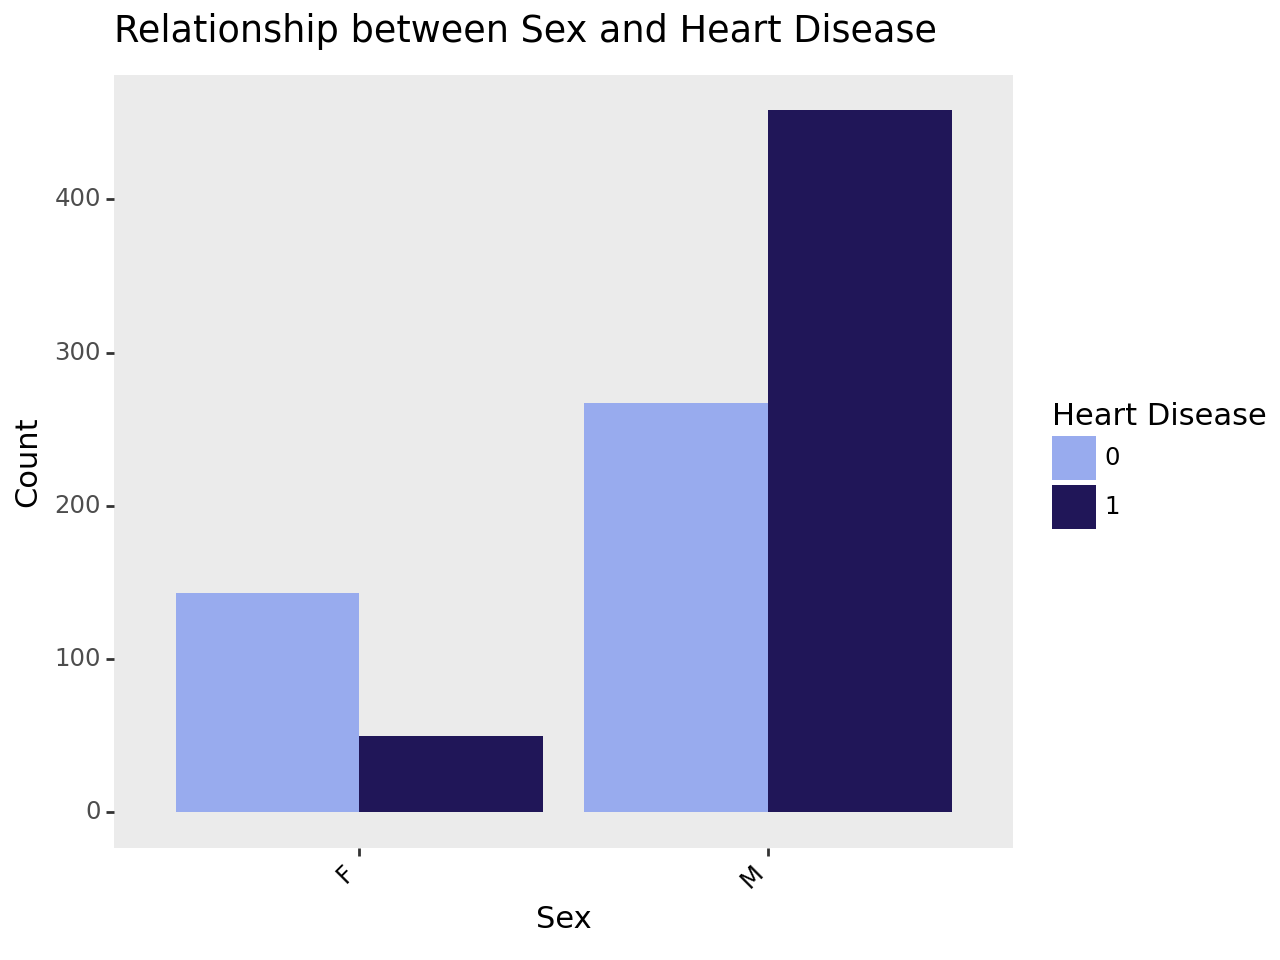

<Figure Size: (640 x 480)>

In [34]:
def plotting(df, column):
        """
        Input: Dataframe and a column to plot
        Output: Bar graph of the relationship of the column selected and having a heart disease
        """
        return (p9.ggplot(df, p9.aes(x=column, fill='factor(HeartDisease)')) + 
                 p9.geom_bar(position='dodge') + 

                 #Adding title and axis
                 p9.labs(title=f'Relationship between {column} and Heart Disease', 
                         x=column, y='Count', fill='Heart Disease') +

                 #Personalizing the grid
                 p9.theme(axis_text_x=p9.element_text(angle=45, hjust=1, color= 'black'),
                         panel_grid_major=p9.element_blank(),
                         panel_grid_minor=p9.element_blank()) +
                 p9.scale_fill_manual(values=['#98ABEE', '#201658']) + 
                 p9.theme(legend_position='right'))

plotting(df, 'Sex')

3. What is the distribution of Chest Pain Type in the dataset?
    * This visualization will help us understand the distribution of chest pain types among the patients in the dataset and identify any potential patterns or trends.
    * we can see that the chest pain of ASY is mostly related to a heart disease. TA is also 50% likely of having a heart disease

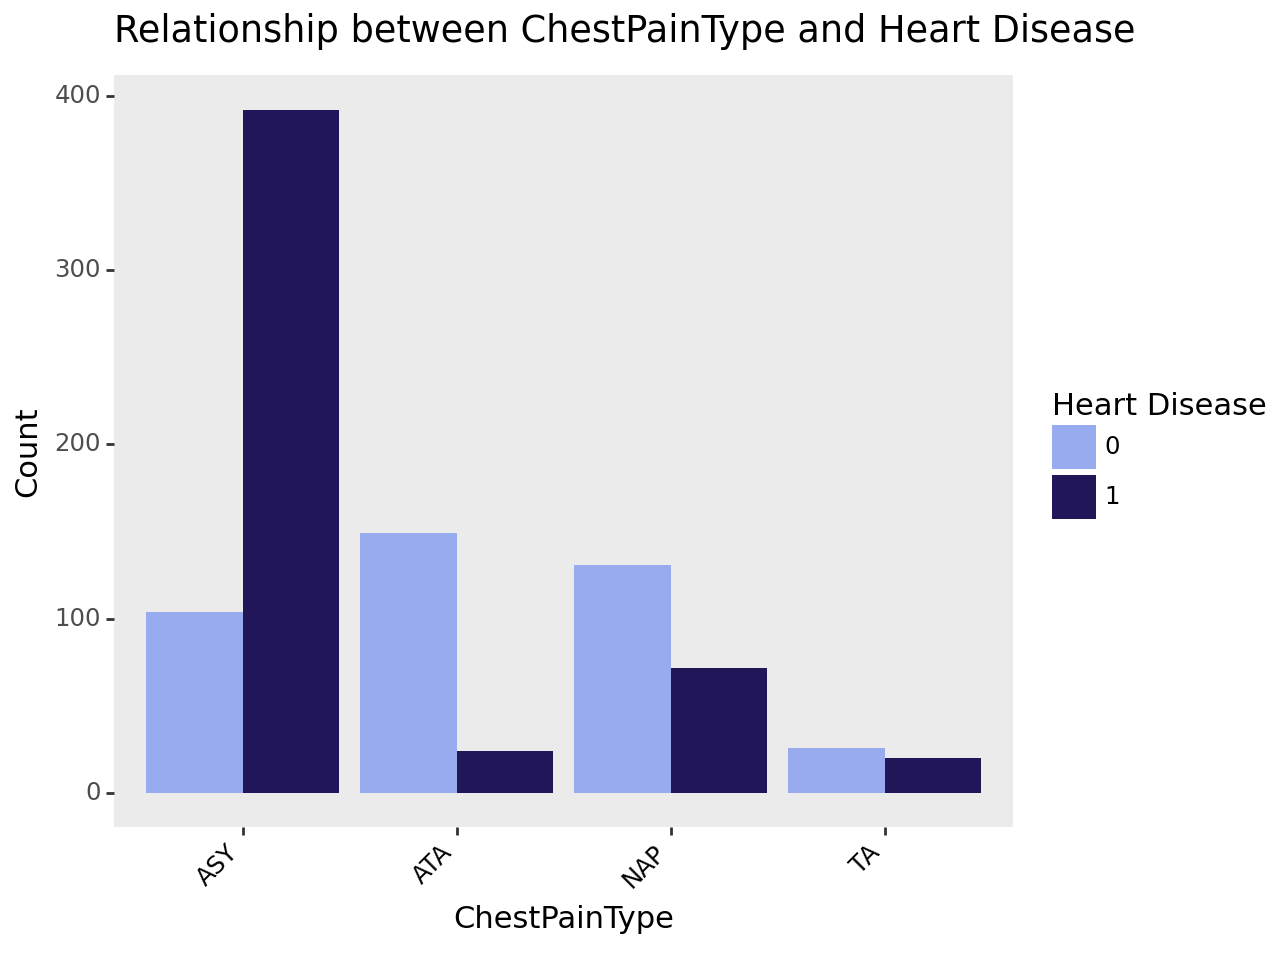

<Figure Size: (640 x 480)>

In [35]:
plotting(df, 'ChestPainType')

4. What is the relationship between exercise-induced angina and heart disease?
    * This visualization will help us understand the relationship between exercise-induced angina and heart disease. It will help us identify if there is a correlation between the two variables and if exercise-induced angina can be used as a predictor for heart disease.
    * we can see that people tend to have a heart disease more often when they have exercise-induced angina.



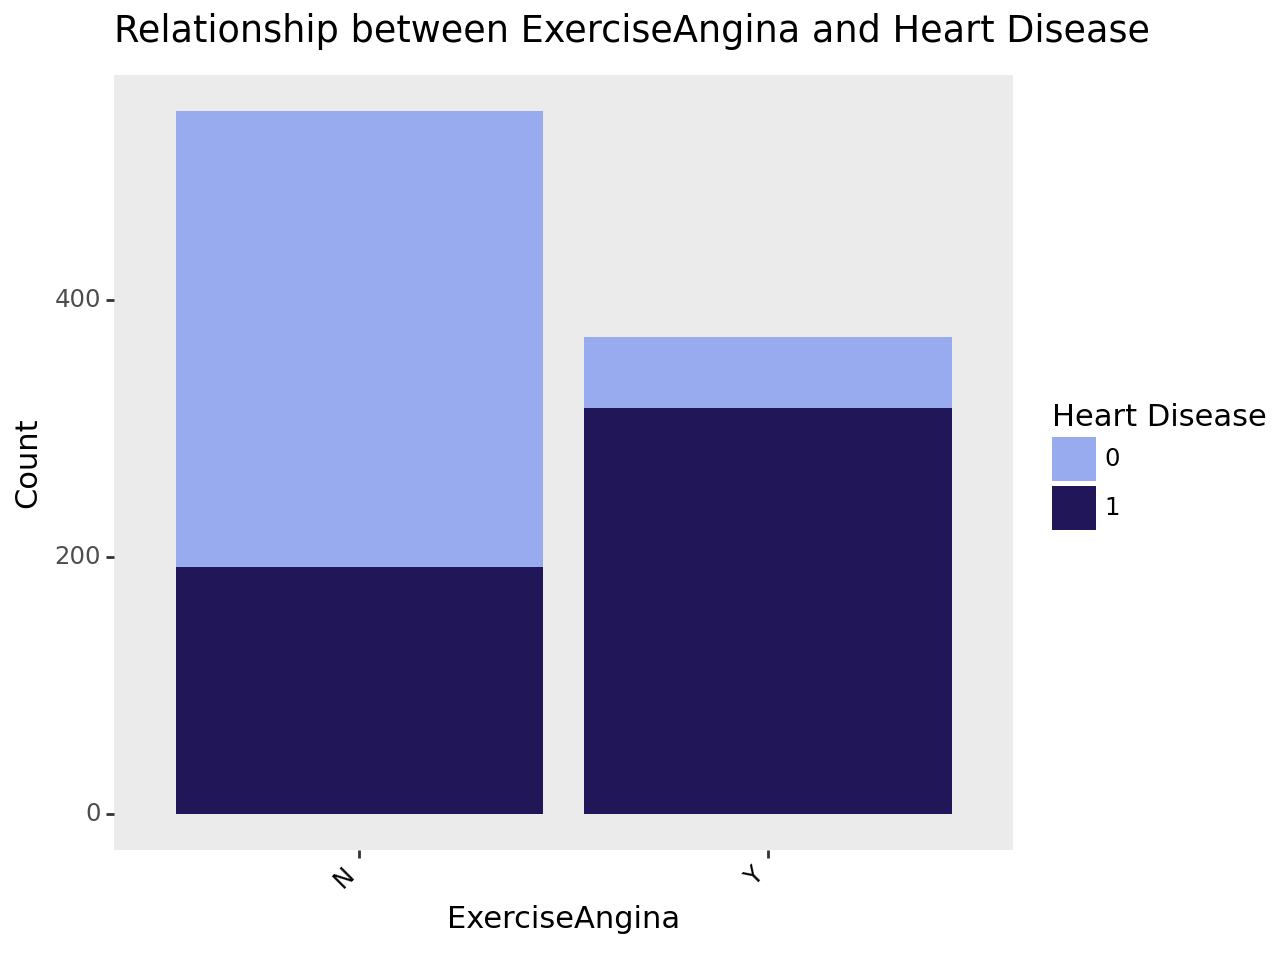

<Figure Size: (640 x 480)>

In [36]:
def plotting2(df, column):
        """
        Input: Dataframe and a column to plot
        Output: Stacked bar graph of the relationship of the column selected and having a heart disease
        """
        return (p9.ggplot(df, p9.aes(x=column, fill='factor(HeartDisease)')) +
            p9.geom_bar(position='stack') +  
            
            #Adding title and axis    
            p9.labs(title=f'Relationship between {column} and Heart Disease',
                    x=column, y='Count', fill='Heart Disease') +
                
            #Personalizing the grid
            p9.theme(axis_text_x=p9.element_text(angle=45, hjust=1, color="black"),
                     panel_grid_major=p9.element_blank(),
                     panel_grid_minor=p9.element_blank()) +
            p9.scale_fill_manual(values=['#98ABEE', '#201658']) +
            p9.theme(legend_position='right'))


plotting2(df, 'ExerciseAngina')

5. What is the relationship between resting ECG  and heart disease?
    * This visualization will help us understand the relationship between resting ECG and heart disease. It will help us identify if there is a correlation between the two variables and if resting ECG can be used as a predictor for heart disease.
    * we can see that in general resting ECG is not as related to having a heart disease or not. IN all of the cases there is 50% of people having a heart disease and the other 50% not having a heart disease. Not the most correlated variable.

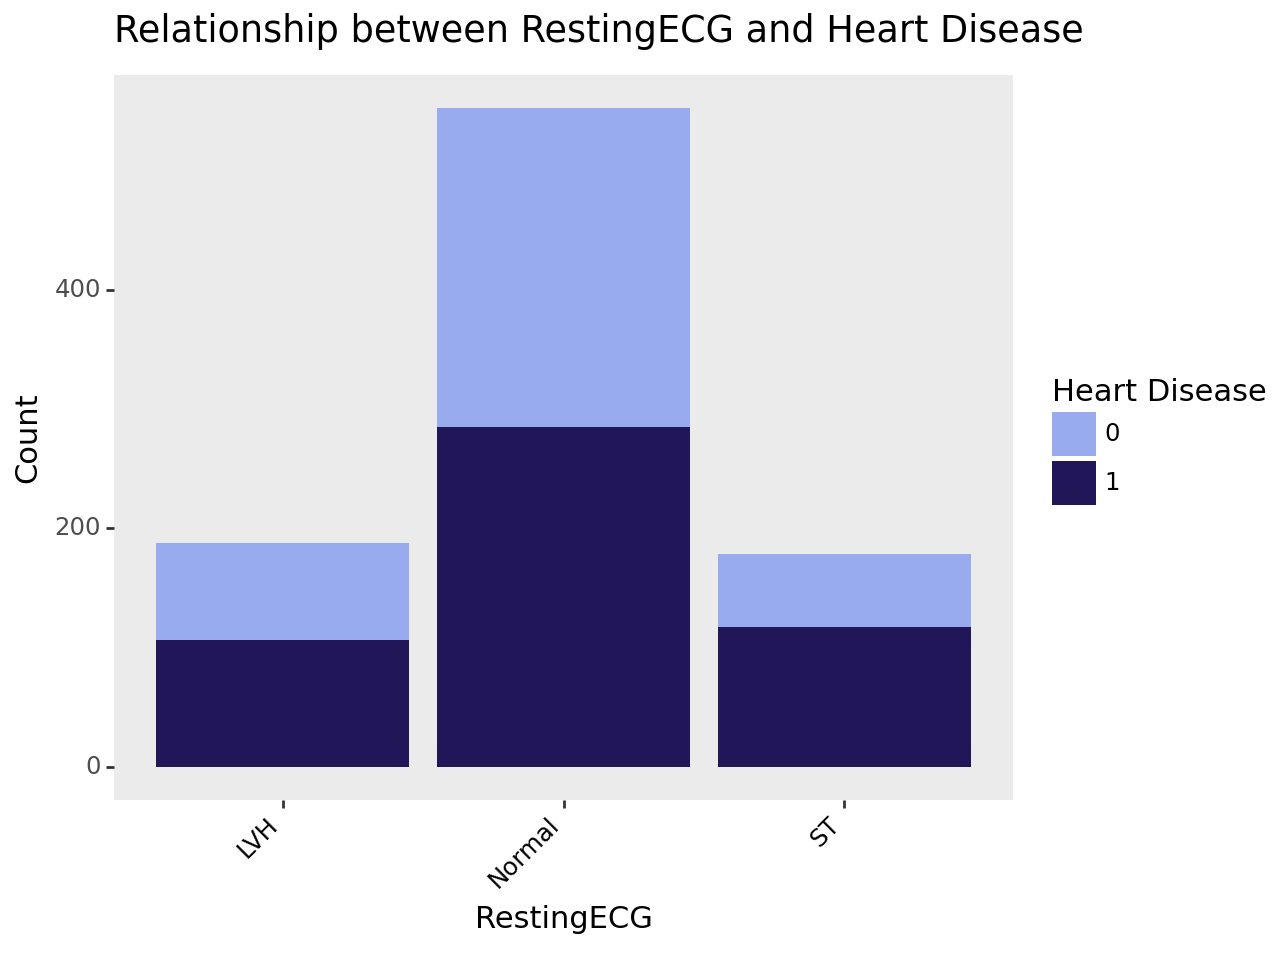

<Figure Size: (640 x 480)>

In [37]:
plotting2(df, 'RestingECG')

6. What is the relationship between ST_Slope  and heart disease?
    * This visualization will help us understand the relationship between ST_Slope and heart disease. It will help us identify if there is a correlation between the two variables and if ST_Slope can be used as a predictor for heart disease.
    * this variables are higly correlated. People that have a 'down' and 'flat' ST_Slope are the patients that tend to be more propense to have a heart disease.

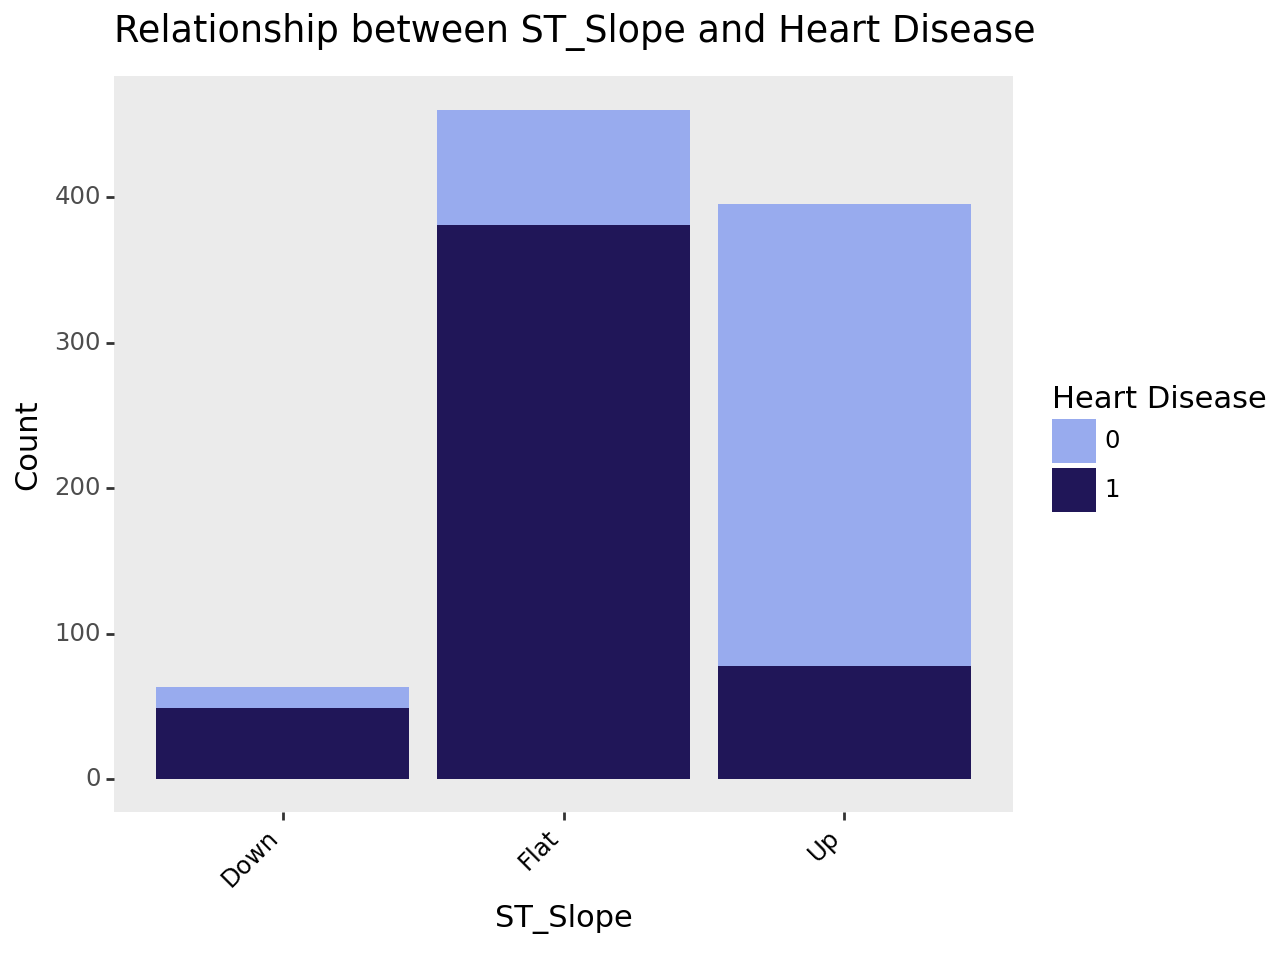

<Figure Size: (640 x 480)>

In [38]:
plotting2(df, 'ST_Slope')

7. What is the distribution of maximum heart rate achieved among patients with heart disease?

    * This visualization will help us understand the distribution of maximum heart rate achieved among patients with heart disease. It will help us identify if there is a specific range of maximum heart rate achieved that is more common among patients with heart disease
    * The most common heart range for people that have a heart disease is around 120.  
    * The most common heart range for people that dont have a hear disease is around 175.
    * People with heart disease are shifted 

In [39]:
def histogram_graph():
    """
    Input: DataFrame 'df' with columns 'HeartDisease' and 'MaxHR'
    Output: Histogram of the relationship between having heart disease and maximum heartbeats
    """
    # Creating a new column 'Group' that transforms numeric values to categorical values
    df['Group'] = df['HeartDisease'].map({1: 'With Heart Disease', 0: 'Without Heart Disease'})
    
    # Calculates the median line for each group
    median_values = df.groupby('Group')['MaxHR'].median().reset_index()
    median_values['Label'] = 'Median'  # Adding a label for the legend

    plot = (
        p9.ggplot(df, p9.aes(x='MaxHR')) +
        p9.geom_histogram(bins=30, fill='blue', alpha=0.5) +
        p9.facet_wrap('~Group') +

        # Adding title and axis to the graph
        p9.labs(title='Distribution of Maximum Heart Rate by Heart Disease Status',
                x='Maximum Heart Rate', y='Count') +

        # Personalizing grid and adding median lines
        p9.theme(axis_text_x=p9.element_text(angle=45, hjust=1)) +
        p9.geom_vline(data=median_values, mapping=p9.aes(xintercept='MaxHR', linetype='Label'), color='red') +
        p9.guides(linetype=p9.guide_legend(title='Statistics')) +
        p9.scale_linetype_manual(values=['dashed'])  # Ensuring the line type is dashed
    )
    
    return plot

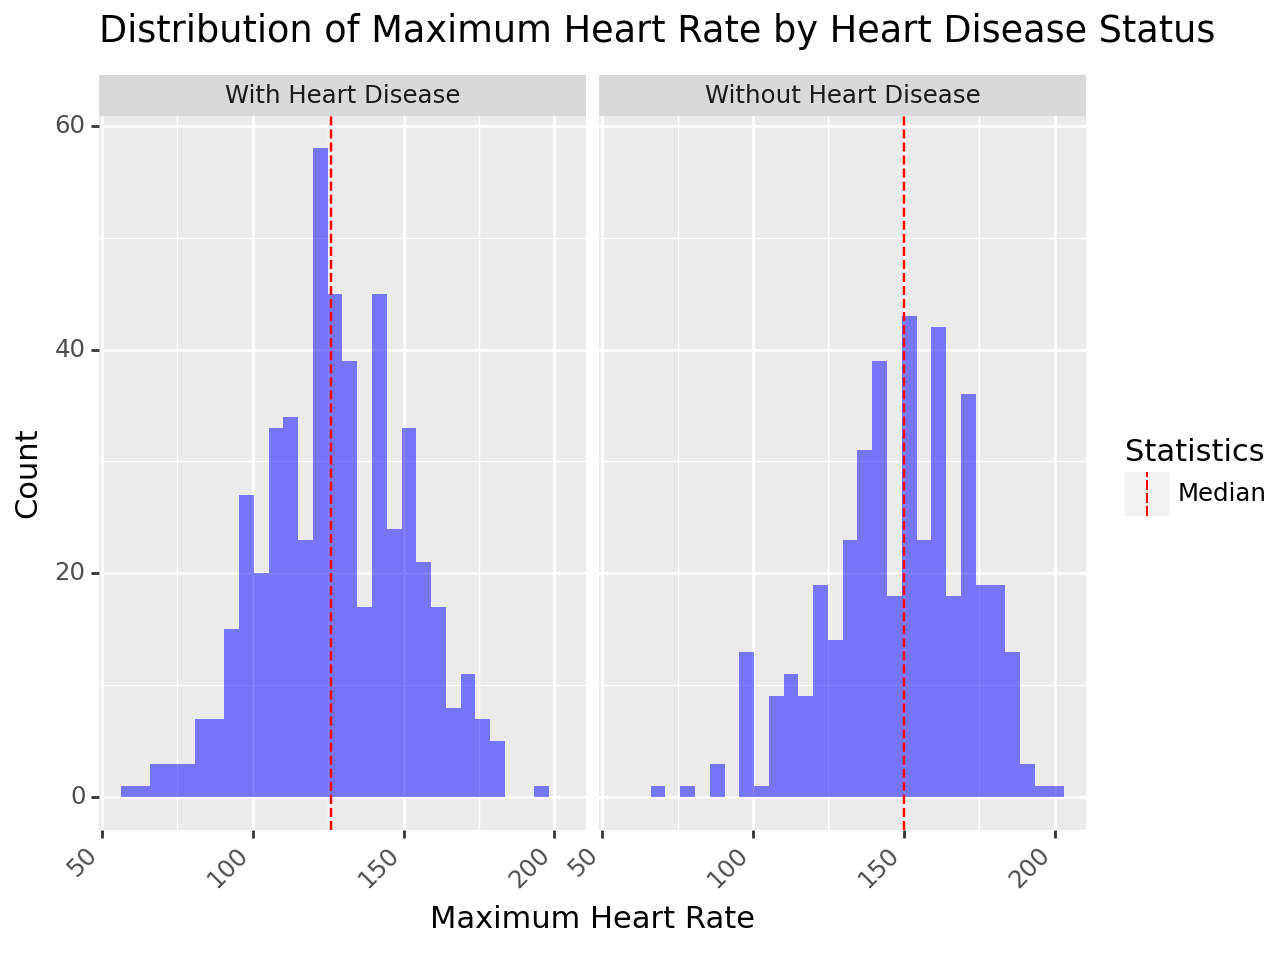

<Figure Size: (640 x 480)>

In [40]:
histogram_graph()

8.What is the relationship between resting blood pressure and heart disease?
This visualization will help us understand the relationship between resting blood pressure and heart disease. It will help us identify if there is a correlation between the two variables and if resting blood pressure can be used as a predictor for heart disease.
we can see that this varibale is not that correlated either to having a heart disease or not.
However, people that have a higher resting blood pressure than the mean, tend to be more likely to have a heart disease. The same trend is going on with cholesterol. Not the most correlated variables in the dataset.

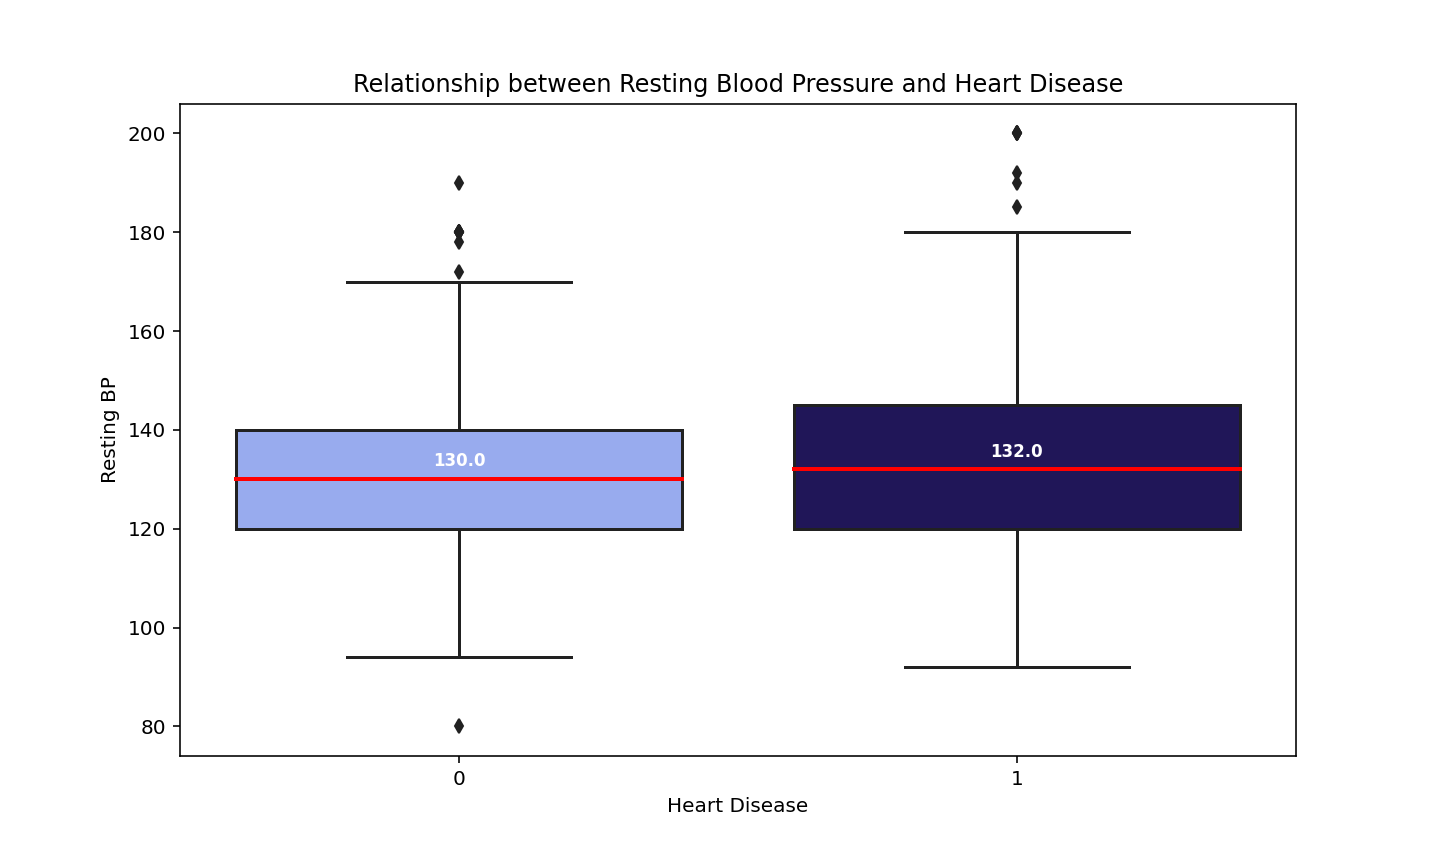

In [42]:
plt.figure(figsize=(10,6))
# Take out outlier zero, take heart disease and RestingBP to create box and whisker; use redline to denote median
zero_set = df[df["RestingBP"] != 0]
bp_plot = sns.boxplot(data=zero_set, x = "HeartDisease", y = "RestingBP", palette=['#98ABEE', '#201658'],
           saturation = 1, medianprops={"color": "r", "linewidth": 2})

# Calculate median for display
medians = zero_set.groupby(['HeartDisease'])['RestingBP'].median()
vertical_offset = zero_set['RestingBP'].median() * 0.02 # offset from median for display

# Add median values and label graph
for xtick in bp_plot.get_xticks():
    bp_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='small',color='w',weight='semibold')
bp_plot = bp_plot.set(title = 'Relationship between Resting Blood Pressure and Heart Disease', xlabel = "Heart Disease",
                     ylabel = "Resting BP")

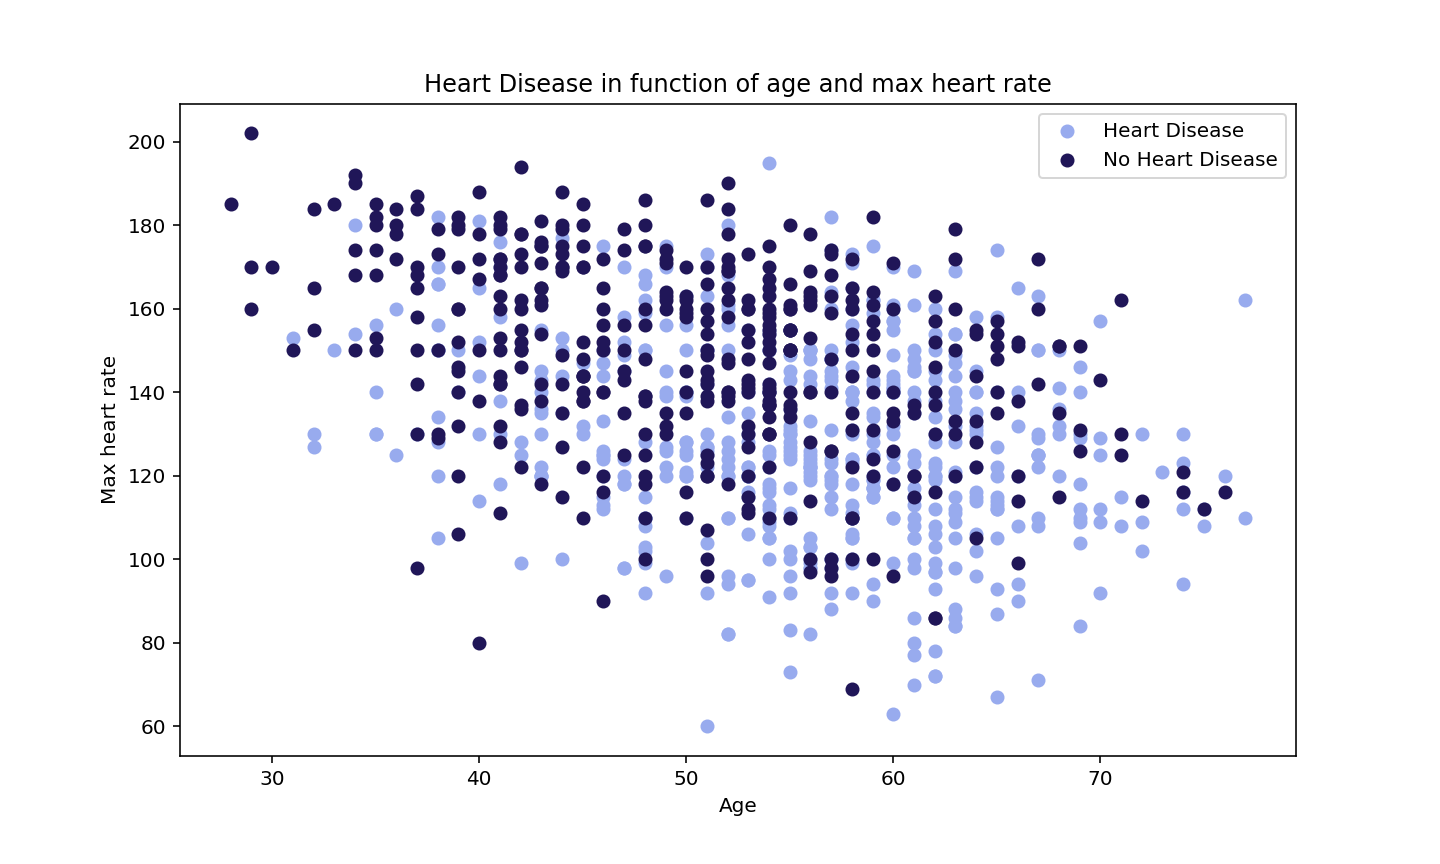

In [41]:
#Checking to see if max heart rate is related with age and heart disease as well
#create a figure
plt.figure(figsize=(10,6))

#scatter with positive examples
plt.scatter(df.Age[df.HeartDisease==1],
           df.MaxHR[df.HeartDisease==1],
           c='#98ABEE')

#scatter with negative examples
plt.scatter(df.Age[df.HeartDisease==0],
           df.MaxHR[df.HeartDisease==0],
           c='#201658')

#Add labels
plt.title('Heart Disease in function of age and max heart rate')
plt.xlabel('Age')
plt.ylabel('Max heart rate')
plt.legend(['Heart Disease', 'No Heart Disease'])
plt.xticks(rotation=0);

# 9.What is the relationship between old peak and heart disease in the dataset?
This visualization will help us understand if the oldpeak value is related to the heart disease
If the old peak values lies outside the range [0,2.5] it is more likely to have a heart disease.

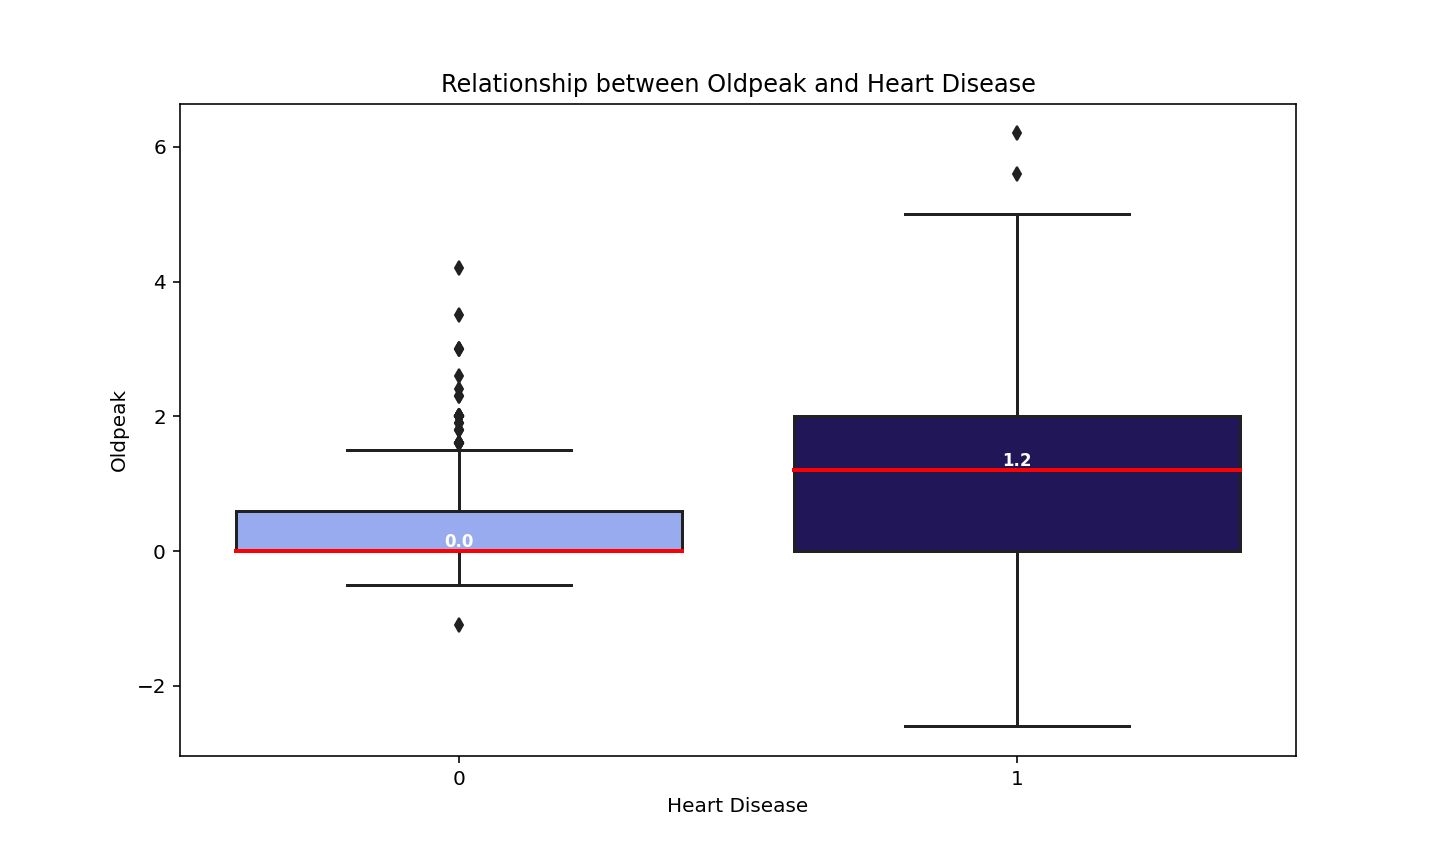

In [43]:
plt.figure(figsize=(10,6))
# Take heart disease and Oldpeak to create box and whisker; use redline to denote median
bp_plot = sns.boxplot(data=df, x = "HeartDisease", y = "Oldpeak",  palette=['#98ABEE', '#201658'],
           saturation = 1, medianprops={"color": "r", "linewidth": 2})

# Calculate median for display
medians = df.groupby(['HeartDisease'])['Oldpeak'].median()

# print(df[df['HeartDisease'] == 0]['Oldpeak'].median()) #0.0
vertical_offset = df['Oldpeak'].median() * 0.10 # offset from median for display

# Add median values and label graph
for xtick in bp_plot.get_xticks():
    bp_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='small',color='w',weight='semibold')
bp_plot = bp_plot.set(title = 'Relationship between Oldpeak and Heart Disease', xlabel = "Heart Disease",
                     ylabel = "Oldpeak")

Checking to see if our variables are correlated
 *  the variables that are mostly correlated:
    * old_peak with heart disease
    * age and oldpeak
    * age with heart diseases
    * heart disease with the maximum heartbeat

We can conclude that the features that affect the most in wether a patient has a heart disease are: old peak, age, and heartbeats


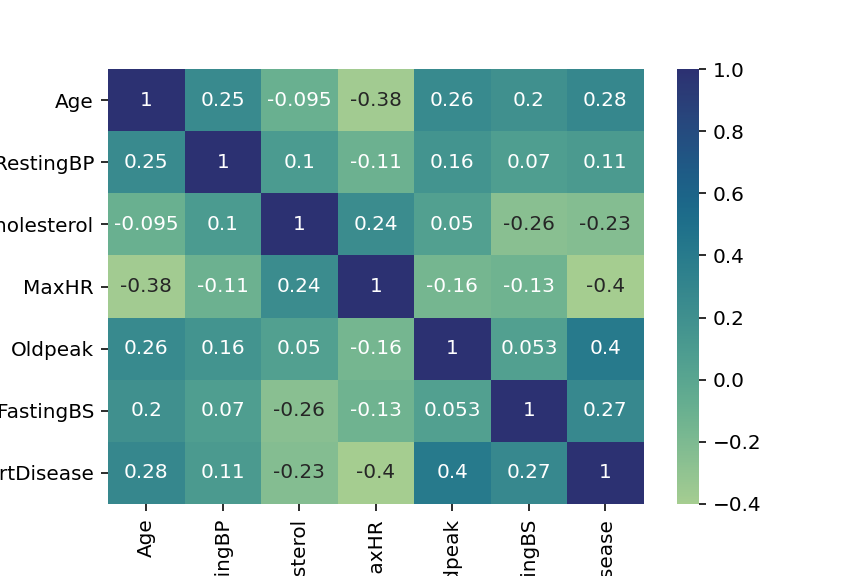

In [44]:
#we must only take intro consideration variables that are numerical
df1=df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS', 'HeartDisease']]

#creating the correlation matrix
corr_matrix=df1.corr()

#creating the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap="crest");

# Preparing the Data

In [45]:
#Definig the features and the target variable
df.drop(columns='Group', axis=1, inplace=True)
y=df['HeartDisease']
X=df.drop(columns=['HeartDisease'],axis=1)
X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up


In [46]:
#Splitting the data into test and training sets
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=11)

In [52]:
def data_preparation(X_train):
    """
    Input: A set of Data
    Output: Return a standarized data frame where all categorical columns have been changed to numerical 
    
    """
    # Define numerical and categorical columns
    numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']
    categorical_columns = ['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope', 'RestingECG']

    # Create a column transformer
    col_transformer = ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore"), categorical_columns)
    ], remainder="passthrough")

    # Create a pipeline containing the single column transformer
    pipe = Pipeline(steps=[
    ("col_transformer",col_transformer),
    ("scale", StandardScaler())
    ])

    # Use the pipeline to fit and transform the data
    transformed_data = pipe.fit_transform(X_train)

    # Extract the category labels from the OHE within the pipeline
    encoder = col_transformer.named_transformers_["ohe"]
    category_labels = encoder.get_feature_names(categorical_columns)

    # Combine category labels with numerical columns
    column_names = np.append(category_labels, numerical_columns)

    # Make a dataframe with the relevant columns and rename columns
    transformed_df = pd.DataFrame(transformed_data, columns=column_names)
    
    #remove the columns that are correlated due to the dummy variable
    transformed_df=transformed_df.drop(columns=['Sex_F', 'ChestPainType_ASY', 'ExerciseAngina_N', 'ST_Slope_Down', 'RestingECG_Normal'], axis=1)

    # Rename one-hot encoded columns with original categorical column names
    return transformed_df


In [53]:
train_df=data_preparation(X_train)
test_df=data_preparation(X_test)
test_df.head()

,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,RestingECG_LVH,RestingECG_ST,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,FastingBS
0,0.543852,1.993232,-0.484664,-0.167132,-0.906522,1.0,-0.829502,-0.560612,-0.476095,-1.385627,0.088211,0.080863,-0.510171,-0.109374,-0.750448
1,0.543852,-0.501698,-0.484664,-0.167132,1.103117,-1.0,1.205543,1.783765,-0.476095,-0.285259,0.322083,0.577967,-0.510171,1.910595,-0.750448
2,0.543852,-0.501698,-0.484664,-0.167132,-0.906522,1.0,-0.829502,-0.560612,-0.476095,-1.715738,0.088211,-1.658999,1.960129,0.563949,-0.750448
3,0.543852,-0.501698,2.063284,-0.167132,1.103117,1.0,-0.829502,-0.560612,-0.476095,-1.275590,-0.613407,0.295132,-0.510171,0.638763,0.617607
4,0.543852,-0.501698,-0.484664,-0.167132,-0.906522,1.0,-0.829502,-0.560612,-0.476095,1.475331,-0.379535,0.517971,1.960129,1.050238,-0.568040


# Random Forest

In [54]:
grid_params ={'criterion': ['gini', 'entropy', 'log_loss'],
                'min_samples_split': [2,5,10],
                'min_samples_leaf': [1,3,8]}

In [55]:
gridsearch = GridSearchCV(RandomForestClassifier(),
                          param_grid=grid_params,
                          scoring='accuracy', 
                          cv=5,
                          verbose=True)

In [56]:
gridsearch.fit(train_df, y_train)
gridsearch.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-package

C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)


C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)


C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)


C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)


C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)


C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)


C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\aarezi\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)


{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2}

In [58]:
gridsearch.score(test_df, y_test)

0.8315217391304348

In [59]:
#creating and fitting the model
modelforest_0=RandomForestClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=2)
modelforest_0.fit(train_df, y_train)

RandomForestClassifier()

In [60]:
modelforest_0.feature_importances_

array([0.03278438, 0.03835216, 0.02418604, 0.01093767, 0.08924943,
       0.11580365, 0.14980405, 0.01880735, 0.0088389 , 0.08039406,
       0.06498463, 0.1104805 , 0.02742089, 0.11201648, 0.11593983])

In [61]:
#checking the coefficients correlation with terms of the target
#matching our coefficients to the feature columns
features_dict=dict(zip(train_df.columns, list(modelforest_0.feature_importances_)))
features_dict

{'Sex_M': 0.03278437975093912,
 'ChestPainType_ATA': 0.03835215567345562,
 'ChestPainType_NAP': 0.024186037621741673,
 'ChestPainType_TA': 0.010937667291600109,
 'ExerciseAngina_Y': 0.08924942829687754,
 'ST_Slope_Flat': 0.11580364594937151,
 'ST_Slope_Up': 0.14980404605539033,
 'RestingECG_LVH': 0.01880735211113751,
 'RestingECG_ST': 0.00883890355317119,
 'Age': 0.08039405879192917,
 'RestingBP': 0.06498462855270755,
 'Cholesterol': 0.11048049579976958,
 'MaxHR': 0.027420887102790035,
 'Oldpeak': 0.1120164826339248,
 'FastingBS': 0.1159398308151942}

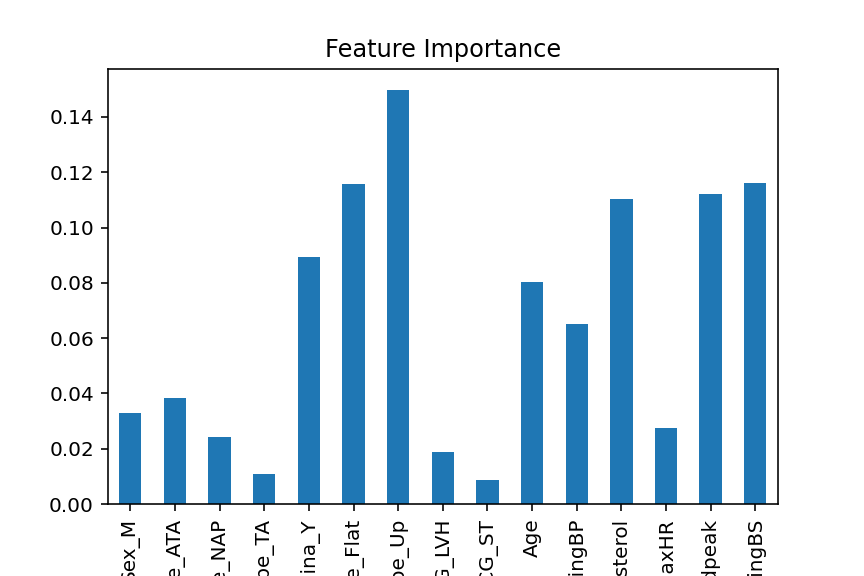

In [62]:
features_df=pd.DataFrame(features_dict, index=[0])
features_df.T.plot.bar(title= 'Feature Importance', legend=False);

In [63]:
train_df.head()

,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,RestingECG_LVH,RestingECG_ST,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,FastingBS
0,0.508925,-0.476891,-0.544812,-0.243235,-0.803579,-1.002729,1.137431,-0.494032,-0.494032,1.210180,-0.689980,-0.215267,-0.561616,0.108323,-0.476118
1,0.508925,-0.476891,-0.544812,-0.243235,1.244432,-1.002729,-0.879174,-0.494032,-0.494032,-1.628757,-1.254768,0.827924,-0.561616,-1.286577,0.563973
2,0.508925,-0.476891,-0.544812,-0.243235,-0.803579,-1.002729,1.137431,-0.494032,-0.494032,-0.261862,-0.125192,-1.863882,1.780577,1.303952,-1.516210
3,-1.964924,-0.476891,-0.544812,-0.243235,1.244432,0.997279,-0.879174,-0.494032,-0.494032,0.894742,1.004384,0.408785,-0.561616,0.666283,0.469420
4,-1.964924,-0.476891,-0.544812,-0.243235,-0.803579,0.997279,-0.879174,-0.494032,-0.494032,1.105034,-0.125192,0.958323,-0.561616,-0.609054,1.036742


In [64]:
#using the model but only with the selected features. 
#We select feature only having where the abs value is 0.5 or above.
feature_importance_train=train_df.drop(columns=['RestingECG_LVH','RestingECG_ST','RestingBP','MaxHR','Sex_M'])
feature_importance_test=test_df.drop(columns=['RestingECG_LVH','RestingECG_ST','RestingBP','MaxHR','Sex_M'])
modelforest_1=RandomForestClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=2)
modelforest_1.fit(feature_importance_train, y_train)

RandomForestClassifier()

In [65]:
modelforest_1.score(feature_importance_test, y_test)

0.8152173913043478